In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
#import keras_tuner as kt              

import pickle
import pydicom
import matplotlib.pyplot as plt
import cv2
import time

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm
import eval_model as ev

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

No Nvidia GPU in system!


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [28]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [29]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [30]:
metadata = pd.read_csv('train.csv')

# Train from scratch

### Image Resolution 256 x 256

In [31]:
# inception from scratch
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

 batch_normalization_99 (BatchN  (None, 29, 29, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 29, 29, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 29, 29, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 29, 29, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 29, 29, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 29, 29, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 29, 29, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 14, 14, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 14, 14, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 14, 14, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 14, 14, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 14, 14, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 14, 14, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 6, 6, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 6, 6, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 6, 6, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

In [36]:
# base_model.summary()
keras.utils.plot_model(inception, show_shapes=True)

In [32]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [33]:
BATCH_SIZE = 4*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train'

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        n_classes=2,
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [13]:
print(len(train_gen), len(val_gen))

218 54


In [14]:
X, y = train_gen[0]
print(X.shape, y.shape)

(128, 256, 256, 3) (128,)


In [15]:
inception.output.shape[-3:]

TensorShape([6, 6, 2048])

## Out of the box

In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [14]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder created:  models/inception_rsna_checkpoint/sgd
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [15]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 01:27:37.117748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1109 - tp: 2.0000 - fp: 126.0000 - tn: 27201.0000 - fn: 575.0000 - accuracy: 0.9749 - precision: 0.0156 - recall: 0.0035 - auc: 0.4962 - prc: 0.0213

2023-04-07 01:50:43.287307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 4.23679, saving model to models/inception_rsna_checkpoint/rsna_256_sgd-lr-default-01-prc0.02-tp0.0-loss4.24.hdf5
218/218 [==============================] - 1479s 7s/step - loss: 0.1109 - tp: 2.0000 - fp: 126.0000 - tn: 27201.0000 - fn: 575.0000 - accuracy: 0.9749 - precision: 0.0156 - recall: 0.0035 - auc: 0.4962 - prc: 0.0213 - val_loss: 4.2368 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1015 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5169 - prc: 0.0218
Epoch 2: val_loss did not improve from 4.23679
218/218 [==============================] - 1476s 7s/step - loss: 0.1015 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.000

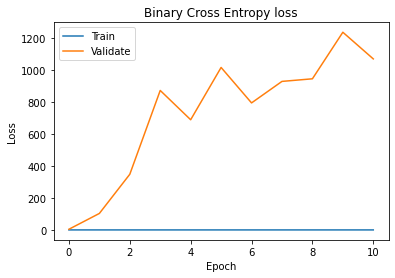

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Use initial bias

In [34]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.83388407]


In [35]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [19]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder created:  models/inception_rsna_checkpoint/sgd
Creating a new model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_3 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    #validation_data=val_generator,
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 06:07:35.624054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1094 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 34096.0000 - fn: 720.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5025 - prc: 0.0205

2023-04-07 06:30:48.674078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 570.91211, saving model to models/inception_rsna_checkpoint/rsna_256_bias_sgd-lr-default-01-prc0.02-tp0.0-loss570.91.hdf5
218/218 [==============================] - 1495s 7s/step - loss: 0.1094 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 34096.0000 - fn: 720.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5025 - prc: 0.0205 - val_loss: 570.9121 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1014 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4943 - prc: 0.0202
Epoch 2: val_loss did not improve from 570.91211
218/218 [==============================] - 1482s 7s/step - loss: 0.1014 - tp: 0.0000e+00 - fp: 0.0000e+00 - t

Epoch 12/100
218/218 [==============================] - ETA: 0s - loss: 0.1008 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4956 - prc: 0.0204
Epoch 12: val_loss did not improve from 262.03918
218/218 [==============================] - 1526s 7s/step - loss: 0.1008 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4956 - prc: 0.0204 - val_loss: 275.6072 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6768.0000 - val_fn: 144.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.1012 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5047 - prc: 0.0211
Epoch 13: val_loss improved from

## Use initial bias and class weight

In [36]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [17]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [23]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))

Epoch 1/100


2023-04-08 22:26:52.700748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4551 - tp: 300.0000 - fp: 14164.0000 - tn: 13161.0000 - fn: 279.0000 - accuracy: 0.4824 - precision: 0.0207 - recall: 0.5181 - auc: 0.5017 - prc: 0.0210

2023-04-08 22:50:06.478441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 13.51013, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr-default-01-prc0.02-tp143.0-loss13.51.hdf5
218/218 [==============================] - 1494s 7s/step - loss: 0.4551 - tp: 300.0000 - fp: 14164.0000 - tn: 13161.0000 - fn: 279.0000 - accuracy: 0.4824 - precision: 0.0207 - recall: 0.5181 - auc: 0.5017 - prc: 0.0210 - val_loss: 13.5101 - val_tp: 143.0000 - val_fp: 6769.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0207 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4530 - tp: 268.0000 - fp: 13428.0000 - tn: 13897.0000 - fn: 311.0000 - accuracy: 0.5076 - precision: 0.0196 - recall: 0.4629 - auc: 0.4778 - prc: 0.0195
Epoch 2: val_loss improved from 13.51013 to 0.99399, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr-default-02-prc0.02-tp0.0-loss0.99.hdf5
218/218 [

>>> Training time:  17971.504817962646


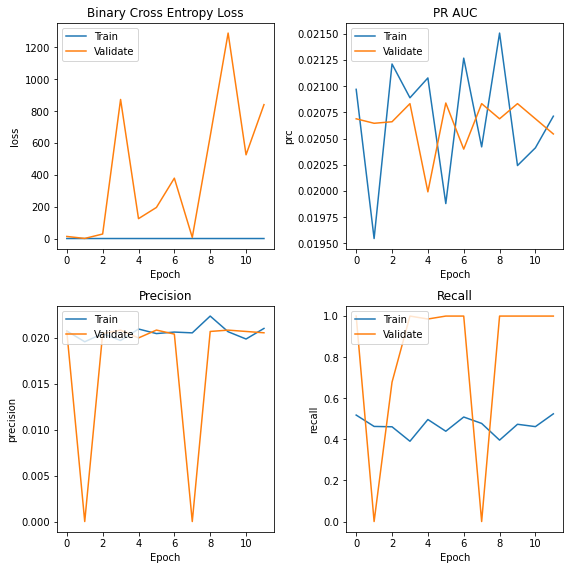

In [24]:
rm.plot_history(history)

### Increase learning rate

In [18]:
LEARNING_RATE = 0.01
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-09 03:33:47.410187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4430 - tp: 425.0000 - fp: 20311.0000 - tn: 13784.0000 - fn: 296.0000 - accuracy: 0.4081 - precision: 0.0205 - recall: 0.5895 - auc: 0.4898 - prc: 0.0203

2023-04-09 03:57:17.297964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 25.32120, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-2-01-prc0.02-tp56.0-loss25.32.hdf5
218/218 [==============================] - 1516s 7s/step - loss: 0.4430 - tp: 425.0000 - fp: 20311.0000 - tn: 13784.0000 - fn: 296.0000 - accuracy: 0.4081 - precision: 0.0205 - recall: 0.5895 - auc: 0.4898 - prc: 0.0203 - val_loss: 25.3212 - val_tp: 56.0000 - val_fp: 1920.0000 - val_tn: 4851.0000 - val_fn: 85.0000 - val_accuracy: 0.7099 - val_precision: 0.0283 - val_recall: 0.3972 - val_auc: 0.5542 - val_prc: 0.0248
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4413 - tp: 267.0000 - fp: 12789.0000 - tn: 14537.0000 - fn: 311.0000 - accuracy: 0.5305 - precision: 0.0205 - recall: 0.4619 - auc: 0.4994 - prc: 0.0206
Epoch 2: val_loss did not improve from 25.32120
218/218 [==============================] - 1497s 7s/step - loss: 0.4413 - tp: 267.0000 - fp: 12789.0000 - tn: 14537.0000 - fn: 311.0000 - acc

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4401 - tp: 230.0000 - fp: 11290.0000 - tn: 16039.0000 - fn: 345.0000 - accuracy: 0.5830 - precision: 0.0200 - recall: 0.4000 - auc: 0.4967 - prc: 0.0203
Epoch 13: val_loss did not improve from 7.82407
218/218 [==============================] - 1503s 7s/step - loss: 0.4401 - tp: 230.0000 - fp: 11290.0000 - tn: 16039.0000 - fn: 345.0000 - accuracy: 0.5830 - precision: 0.0200 - recall: 0.4000 - auc: 0.4967 - prc: 0.0203 - val_loss: 85.5300 - val_tp: 64.0000 - val_fp: 4372.0000 - val_tn: 2397.0000 - val_fn: 79.0000 - val_accuracy: 0.3560 - val_precision: 0.0144 - val_recall: 0.4476 - val_auc: 0.3901 - val_prc: 0.0160
Epoch 14/100
218/218 [==============================] - ETA: 0s - loss: 0.4403 - tp: 271.0000 - fp: 13809.0000 - tn: 13517.0000 - fn: 307.0000 - accuracy: 0.4941 - precision: 0.0192 - recall: 0.4689 - auc: 0.4882 - prc: 0.0198
Epoch 14: val_loss did not improve from 7.82407
218/218 [=====================

In [20]:
model.load_weights('models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-2-17-prc0.02-tp2.0-loss7.42.hdf5')

In [22]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))

2023-04-10 01:11:01.019548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
218/218 [==============================] - ETA: 0s - loss: 0.4408 - tp: 260.0000 - fp: 12284.0000 - tn: 15039.0000 - fn: 321.0000 - accuracy: 0.5483 - precision: 0.0207 - recall: 0.4475 - auc: 0.4921 - prc: 0.0199

2023-04-10 01:34:12.295798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 11.10562, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-2-01-prc0.02-tp21.0-loss11.11.hdf5
218/218 [==============================] - 1491s 7s/step - loss: 0.4408 - tp: 260.0000 - fp: 12284.0000 - tn: 15039.0000 - fn: 321.0000 - accuracy: 0.5483 - precision: 0.0207 - recall: 0.4475 - auc: 0.4921 - prc: 0.0199 - val_loss: 11.1056 - val_tp: 21.0000 - val_fp: 1235.0000 - val_tn: 5535.0000 - val_fn: 121.0000 - val_accuracy: 0.8038 - val_precision: 0.0167 - val_recall: 0.1479 - val_auc: 0.4768 - val_prc: 0.0190
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4396 - tp: 227.0000 - fp: 11421.0000 - tn: 15906.0000 - fn: 350.0000 - accuracy: 0.5782 - precision: 0.0195 - recall: 0.3934 - auc: 0.4948 - prc: 0.0203
Epoch 2: val_loss did not improve from 11.10562
218/218 [==============================] - 1487s 7s/step - loss: 0.4396 - tp: 227.0000 - fp: 11421.0000 - tn: 15906.0000 - fn: 350.0000 - ac

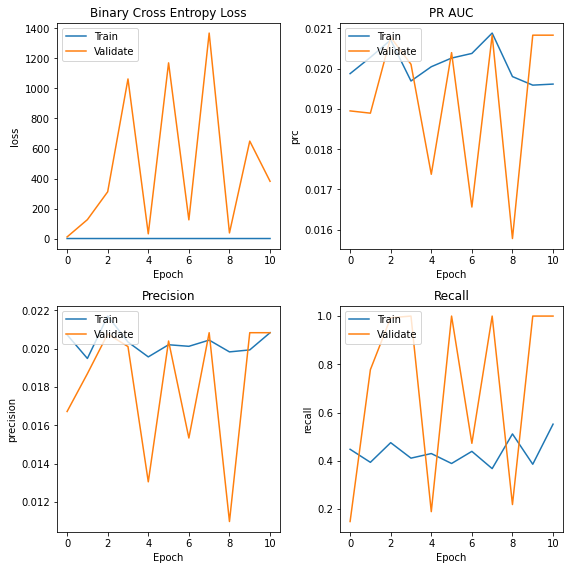

In [23]:
ev.plot_history(history)

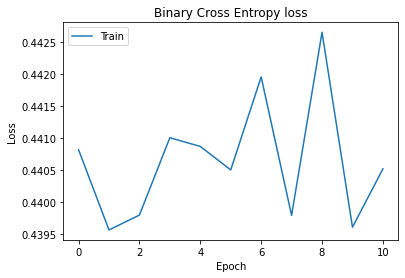

In [24]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Decrease learning rate

In [25]:
LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [26]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-10 05:59:38.980949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4394 - tp: 723.0000 - fp: 34093.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5003 - prc: 0.0208

2023-04-10 06:23:08.726322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 520.05646, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-5-01-prc0.02-tp144.0-loss520.06.hdf5
218/218 [==============================] - 1507s 7s/step - loss: 0.4394 - tp: 723.0000 - fp: 34093.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5003 - prc: 0.0208 - val_loss: 520.0565 - val_tp: 144.0000 - val_fp: 6768.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4401 - tp: 581.0000 - fp: 27323.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5000 - prc: 0.0208
Epoch 2: val_loss did not improve from 520.05646
218/218 [==============================] - 1504s 7s/step - loss: 0.4401 - tp: 581.0000 - fp: 27323.0000 - tn: 0.0000e+00 - fn: 

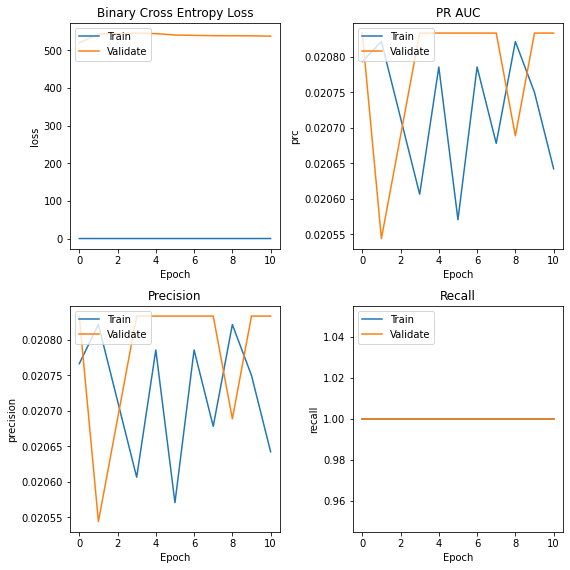

In [27]:
ev.plot_history(history)

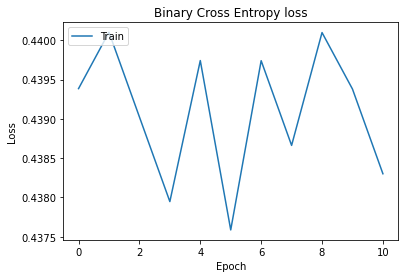

In [28]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Increase batch size from 4 x 32 to 8 x 32

In [37]:
BATCH_SIZE = 8*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train'

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        n_classes=2,
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [38]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [15]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-10 23:55:28.633158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4492 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5239 - prc: 0.0226

2023-04-11 00:04:06.799020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.18751, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr1e-5-01-prc0.03-tp2.0-loss0.19.hdf5
109/109 [==============================] - 662s 6s/step - loss: 0.4492 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5239 - prc: 0.0226 - val_loss: 0.1875 - val_tp: 2.0000 - val_fp: 46.0000 - val_tn: 6722.0000 - val_fn: 142.0000 - val_accuracy: 0.9728 - val_precision: 0.0417 - val_recall: 0.0139 - val_auc: 0.5236 - val_prc: 0.0256
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4450 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27323.0000 - fn: 581.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5033 - prc: 0.0212
Epoch 2: val_loss did not improve from 0.18751
109/109 [==============================] - 659s 6s/step - loss: 0.4450 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27323.000

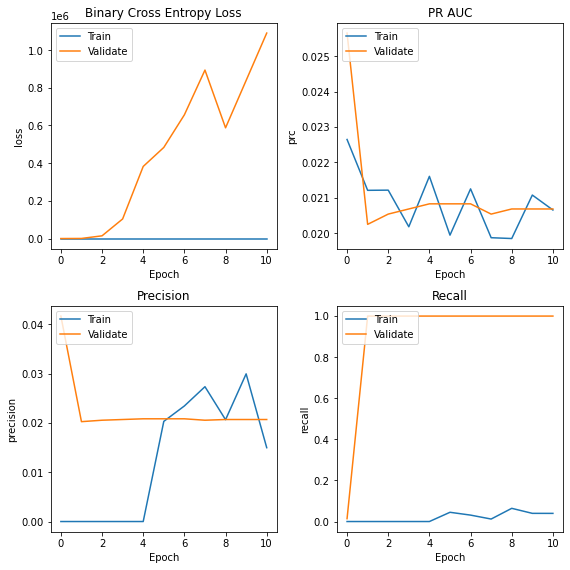

In [16]:
ev.plot_history(history)

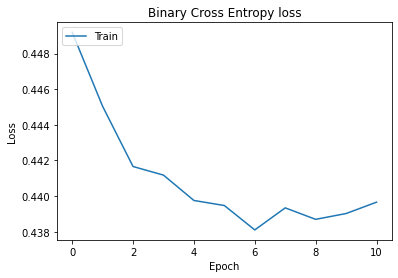

In [17]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

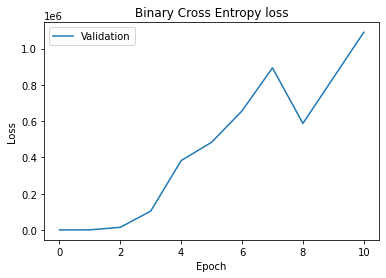

In [18]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Freeze and save weights from epoch 1 which has the lowest validation loss for predictions

In [39]:
model.load_weights('models/inception_rsna_checkpoint/selected_models/rsna_256_bias_weights_batch256_sgd-lr1e-5-01-prc0.03-tp2.0-loss0.19.hdf5')

model.trainable = False
model.save('models/inception_imagenet_checkpoint/selected_models/rsna_256_batch256_sgd_lr1e-5_epoch1_frozen.hdf5')

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 0
Non-trainable params: 21,804,833
_________________________________________________________________


### Increase learning rate to 5e-5 and batch size to 8 x 32

In [17]:
BATCH_SIZE = 8*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train'

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        n_classes=2,
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [18]:
LEARNING_RATE = 0.00005
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder created:  models/inception_rsna_checkpoint/sgd
Creating a new model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr5e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-11 11:21:45.769542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4390 - tp: 233.0000 - fp: 11031.0000 - tn: 23063.0000 - fn: 489.0000 - accuracy: 0.6691 - precision: 0.0207 - recall: 0.3227 - auc: 0.4991 - prc: 0.0207

2023-04-11 11:31:08.350836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1081814.87500, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr5e-5-01-prc0.02-tp143.0-loss1081814.88.hdf5
109/109 [==============================] - 720s 6s/step - loss: 0.4390 - tp: 233.0000 - fp: 11031.0000 - tn: 23063.0000 - fn: 489.0000 - accuracy: 0.6691 - precision: 0.0207 - recall: 0.3227 - auc: 0.4991 - prc: 0.0207 - val_loss: 1081814.8750 - val_tp: 143.0000 - val_fp: 6769.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0207 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4401 - tp: 221.0000 - fp: 10275.0000 - tn: 17048.0000 - fn: 360.0000 - accuracy: 0.6189 - precision: 0.0211 - recall: 0.3804 - auc: 0.4998 - prc: 0.0208
Epoch 2: val_loss improved from 1081814.87500 to 994617.50000, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr5e-5-02-prc

In [19]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr5e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

2023-04-11 22:30:59.656237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.4513 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4917 - prc: 0.0198 

2023-04-11 22:56:03.300488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.52332, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr5e-5-01-prc0.02-tp140.0-loss1.52.hdf5
109/109 [==============================] - 1721s 15s/step - loss: 0.4513 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4917 - prc: 0.0198 - val_loss: 1.5233 - val_tp: 140.0000 - val_fp: 6666.0000 - val_tn: 104.0000 - val_fn: 2.0000 - val_accuracy: 0.0353 - val_precision: 0.0206 - val_recall: 0.9859 - val_auc: 0.5065 - val_prc: 0.0193
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4395 - tp: 22.0000 - fp: 1002.0000 - tn: 26323.0000 - fn: 557.0000 - accuracy: 0.9441 - precision: 0.0215 - recall: 0.0380 - auc: 0.5062 - prc: 0.0211 
Epoch 2: val_loss did not improve from 1.52332
109/109 [==============================] - 1647s 15s/step - loss: 0.4395 - tp: 22.0000 - fp: 1002.0000 - tn: 26323.0000 - fn: 

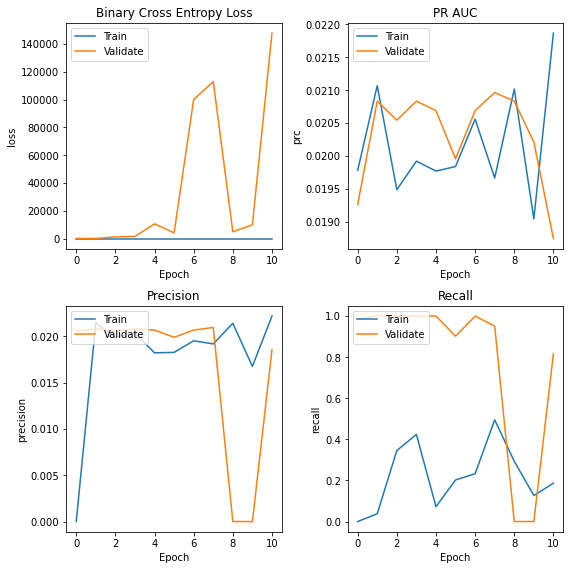

In [20]:
ev.plot_history(history)

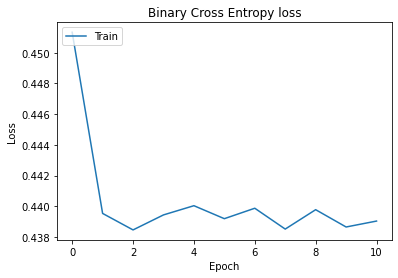

In [21]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

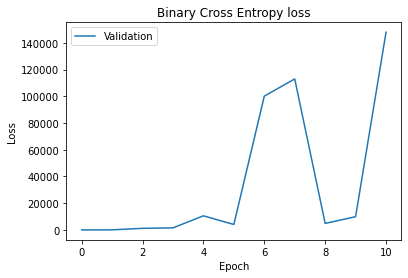

In [22]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

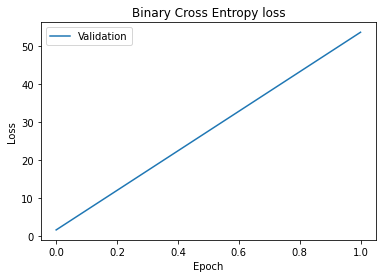

In [25]:
plt.plot(history.history['val_loss'][:2])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Decrease learning rate to 1e-6

In [19]:
LEARNING_RATE = 1e-6
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-11 02:16:31.898031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4393 - tp: 224.0000 - fp: 10272.0000 - tn: 23822.0000 - fn: 498.0000 - accuracy: 0.6907 - precision: 0.0213 - recall: 0.3102 - auc: 0.5025 - prc: 0.0209

2023-04-11 02:25:22.696187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1443691.75000, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr1e-6-01-prc0.02-tp142.0-loss1443691.75.hdf5
109/109 [==============================] - 648s 5s/step - loss: 0.4393 - tp: 224.0000 - fp: 10272.0000 - tn: 23822.0000 - fn: 498.0000 - accuracy: 0.6907 - precision: 0.0213 - recall: 0.3102 - auc: 0.5025 - prc: 0.0209 - val_loss: 1443691.7500 - val_tp: 142.0000 - val_fp: 6770.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0205 - val_precision: 0.0205 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0205
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4389 - tp: 76.0000 - fp: 3764.0000 - tn: 23562.0000 - fn: 502.0000 - accuracy: 0.8471 - precision: 0.0198 - recall: 0.1315 - auc: 0.5026 - prc: 0.0207
Epoch 2: val_loss improved from 1443691.75000 to 1289920.75000, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr1e-6-02-prc0

109/109 [==============================] - 630s 5s/step - loss: 0.4396 - tp: 124.0000 - fp: 6276.0000 - tn: 21048.0000 - fn: 456.0000 - accuracy: 0.7587 - precision: 0.0194 - recall: 0.2138 - auc: 0.5035 - prc: 0.0211 - val_loss: 1389645.6250 - val_tp: 144.0000 - val_fp: 6768.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 25/100
109/109 [==============================] - ETA: 0s - loss: 0.4380 - tp: 72.0000 - fp: 3512.0000 - tn: 23816.0000 - fn: 504.0000 - accuracy: 0.8561 - precision: 0.0201 - recall: 0.1250 - auc: 0.5031 - prc: 0.0206
Epoch 25: val_loss did not improve from 1165050.50000
109/109 [==============================] - 682s 6s/step - loss: 0.4380 - tp: 72.0000 - fp: 3512.0000 - tn: 23816.0000 - fn: 504.0000 - accuracy: 0.8561 - precision: 0.0201 - recall: 0.1250 - auc: 0.5031 - prc: 0.0206 - val_loss: 1334272.6250 - val_tp: 143.0000 - val_fp: 6769.0000 - val_tn: 0.

Epoch 36/100
109/109 [==============================] - ETA: 0s - loss: 0.4377 - tp: 33.0000 - fp: 1503.0000 - tn: 25826.0000 - fn: 542.0000 - accuracy: 0.9267 - precision: 0.0215 - recall: 0.0574 - auc: 0.5051 - prc: 0.0213
Epoch 36: val_loss improved from 1043566.43750 to 1002535.06250, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_sgd-lr1e-6-36-prc0.02-tp142.0-loss1002535.06.hdf5
109/109 [==============================] - 622s 5s/step - loss: 0.4377 - tp: 33.0000 - fp: 1503.0000 - tn: 25826.0000 - fn: 542.0000 - accuracy: 0.9267 - precision: 0.0215 - recall: 0.0574 - auc: 0.5051 - prc: 0.0213 - val_loss: 1002535.0625 - val_tp: 142.0000 - val_fp: 6770.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0205 - val_precision: 0.0205 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0205
Epoch 37/100
109/109 [==============================] - ETA: 0s - loss: 0.4397 - tp: 131.0000 - fp: 6269.0000 - tn: 21055.0000 - fn: 449.0000 - accuracy:

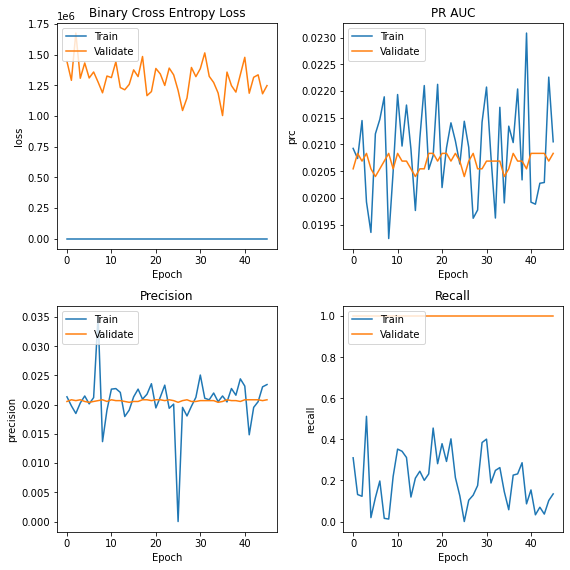

In [23]:
ev.plot_history(history)

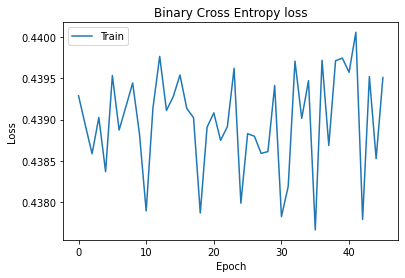

In [22]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

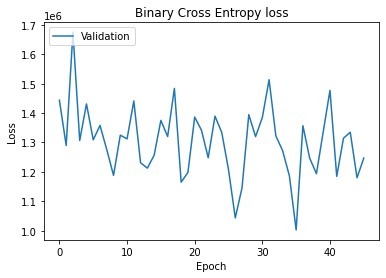

In [21]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Try learning rate 0.0001

In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

LEARNING_RATE = 0.0001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='models/inception_rsna_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [22]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = 'models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-10 10:48:14.872720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100


2023-04-10 10:49:31.311643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


218/218 [==============================] - ETA: 0s - loss: 0.4397 - tp: 294.0000 - fp: 13786.0000 - tn: 13541.0000 - fn: 283.0000 - accuracy: 0.4958 - precision: 0.0209 - recall: 0.5095 - auc: 0.5048 - prc: 0.0209

2023-04-10 10:57:26.092839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 432.59769, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_sgd-lr1e-4-01-prc0.02-tp144.0-loss432.60.hdf5
218/218 [==============================] - 688s 3s/step - loss: 0.4397 - tp: 294.0000 - fp: 13786.0000 - tn: 13541.0000 - fn: 283.0000 - accuracy: 0.4958 - precision: 0.0209 - recall: 0.5095 - auc: 0.5048 - prc: 0.0209 - val_loss: 432.5977 - val_tp: 144.0000 - val_fp: 6768.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4410 - tp: 307.0000 - fp: 14157.0000 - tn: 13166.0000 - fn: 274.0000 - accuracy: 0.4828 - precision: 0.0212 - recall: 0.5284 - auc: 0.4884 - prc: 0.0197
Epoch 2: val_loss did not improve from 432.59769
218/218 [==============================] - 444s 2s/step - loss: 0.4410 - tp: 307.0000 - fp: 14157.0000 - tn: 13166.0000 - fn: 274.00

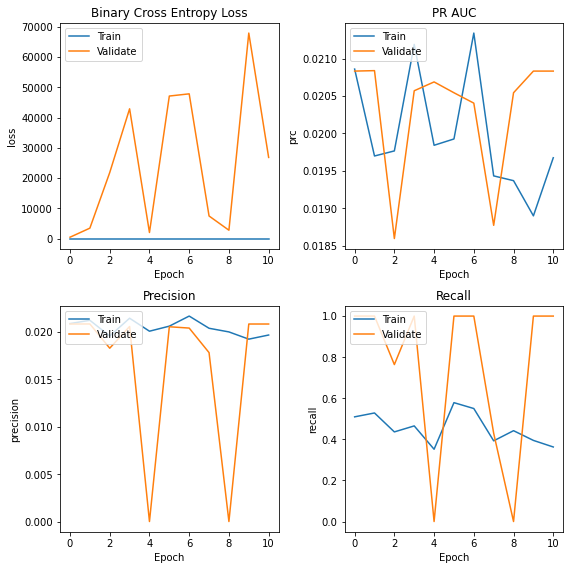

In [23]:
ev.plot_history(history)

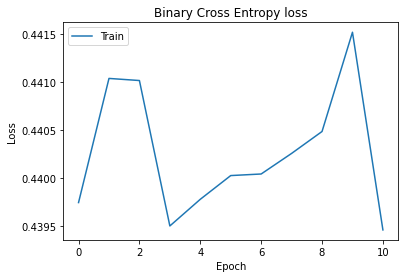

In [24]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()